In [1]:
import os
import numpy as np
import pandas as pd

# from archetypal.schedule import Schedule
from archetypal import UmiTemplateLibrary
from pyumi.shoeboxer.shoebox import ShoeBox

import plotly.graph_objects as go
import plotly.express as px
path = os.getcwd()
epw_path = os.path.join('data', 'CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw')
template_path = os.path.join('data', 'BostonTemplateLibrary.json')

In [2]:
def shoebox_from_template(
        name,
        template,
        zone_params=None,
        wwr=None,
        epw_path="C:/Users/zoele/Git_Repos/nested_grey_box/nested_grey_box/data/COMBINED_TRAINING.epw",
        path=None,
    ):
        """
        Builds idf from archetypal umi template and zone parameters
        zone_params: {
            "width": float (m)
            "height": float (m)
            "length": float (m)
            "facade_2_floor": float # facade area / total footprint area
            "core_2_perim": float # core area / perimeter area, core area = total area/perimeter area
            "roof_2_floor": float
            "footprint_2_floor": float
            "shading_fact": float (0-1)
        }
        """
        if zone_params is None:
            zone_params = {
                "width": 3.0,
                "height": 3.0,
                "facade_2_footprint": 0.3,
                "perim_2_footprint": 0.5,
                "roof_2_ground": 0.5,
                "footprint_2_ground": 0.5,
                "shading_fact": 0.8,
            }

        if wwr is None:
            wwr = 0.4

        wwr_map = {0: 0, 90: 0, 180: wwr, 270: 0}  # N is 0, E is 90
        # Convert to coords
        width = zone_params["width"]
        depth = zone_params["height"] / zone_params["facade_2_footprint"]
        perim_depth = depth * zone_params["perim_2_footprint"]
        zones_data = [
            {
                "name": "Perim",
                "coordinates": [
                    (width, 0),
                    (width, perim_depth),
                    (0, perim_depth),
                    (0, 0),
                ],
                "height": 3,
                "num_stories": 1,
                "zoning": "by_storey",
            },
            {
                "name": "Core",
                "coordinates": [
                    (width, perim_depth),
                    (width, depth),
                    (0, depth),
                    (0, perim_depth),
                ],
                "height": 3,
                "num_stories": 1,
                "zoning": "by_storey",
            },
        ]

        # if cls.verbose:
        #     print("Window to wall ratio assigned: ", wwr)
        #     print("Zone geometry assigned: ", zones_data)

        # zone_def = {
        #     "Core": template.Perimeter.to_dict(),
        #     "Perimeter": template.Perimeter.to_dict(),
        # }

        try:
            sb = ShoeBox.from_template(
                building_template=template,
                zones_data=zones_data,
                wwr_map=wwr_map,
            )
            sb.epw = epw_path
            print("Shoebox: ", sb)

            # Set floor and roof geometry for each zone
            for surface in sb.getsurfaces(surface_type="roof"):
                name = surface.Name
                name = name.replace("Roof", "Ceiling")
                sb.add_adiabatic_to_surface(surface, name, zone_params["roof_2_ground"])
            for surface in sb.getsurfaces(surface_type="floor"):
                name = surface.Name
                name = name.replace("Floor", "Int Floor")
                sb.add_adiabatic_to_surface(
                    surface, name, zone_params["footprint_2_ground"]
                )
            # Internal partition and glazing
            # Orientation

            if path is None:
                path = os.path.join(os.getcwd(), "tests")
            filepath = os.path.join(path, name + ".idf")
            # if cls.verbose:
            #     print("Saving idf at ", filepath)
            sb.saveas(filepath)
        except:
            # TODO: add what the error is from eplus
            sb = f"Error creating shoebox for {name}"

        # Ensure calculation of radiation on floor
        # Ensure 15 min time step

        return sb, zone_params

INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.


Shoebox:  de9607de-c82f-11ed-900b-38fc98b257ef.idf
{'width': 3.0, 'height': 3.0, 'facade_2_footprint': 0.3, 'perim_2_footprint': 0.5, 'roof_2_ground': 0.5, 'footprint_2_ground': 0.5, 'shading_fact': 0.8}


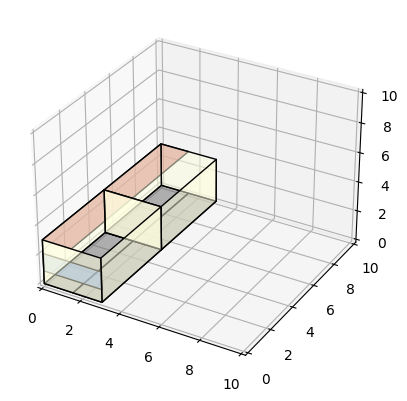

<Figure size 640x480 with 0 Axes>

INFO:archetypal:Showed the plot in 0.01 seconds


CPU times: total: 1.3 s
Wall time: 1.78 s


(<Figure size 640x480 with 0 Axes>, [])

In [4]:
%%time

templates = UmiTemplateLibrary.open(template_path)
sb, zone_params = shoebox_from_template(name="test", template=templates.BuildingTemplates[0], epw_path=epw_path)

# MAKE WALLS ADIABATIC

print(zone_params)
sb.view_model()

In [5]:
bldg = templates.BuildingTemplates[0]
print(bldg.Windows.Construction.r_value)
print(bldg.Perimeter.Constructions.Facade.r_value)
print(bldg.Perimeter.Constructions.Ground.r_value)
print(bldg.Perimeter.Constructions.Roof.r_value)

0.14636792835157625
2.0634227016295936
0.7129972504972506
3.2471832221832226


### Simulate

In [ ]:
%%time

# Node temps
# Zone,Average,CondFD Surface Temperature Node <1 – N> [C]
# Internal zone temps
# Internal MRT
# Internal RH

# Total heat transfer through zone envelope (total, radiation, conduction)
# Surface heat transfer through opaque (conduction, total)
# Surface heat storage rate (total, gain, loss) or Surface Heat Storage Energy
# Internal and external convection coeff

# Infiltration
# Zone air mixing

# Total heating energy
# Total cooling energy

outputs_to_add = [
    # dict(
    #     key="OUTPUT:VARIABLE",
    #     Variable_Name="Surface Heat Storage Energy",
    #     Reporting_Frequency="hourly",
    # ),
    # dict(
    #     key="OUTPUT:VARIABLE",
    #     Variable_Name="Zone Opaque Surface Inside Faces Total Conduction Heat Gain Energy",
    #     Reporting_Frequency="hourly",
    # ),
    # dict(
    #     key="OUTPUT:VARIABLE",
    #     Variable_Name="Zone Opaque Surface Inside Faces Total Conduction Heat Loss Energy",
    #     Reporting_Frequency="hourly",
    # ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Outdoor Air Drybulb Temperature",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Outdoor Air Wind Speed",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Air Temperature",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Operative Temperature",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Ideal Loads Zone Total Heating Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Ideal Loads Zone Total Cooling Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone People Total Heating Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Electric Equipment Convective Heating Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Electric Equipment Radiant Heating Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Lights Total Heating Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:VARIABLE",
        Variable_Name="Zone Windows Total Transmitted Solar Radiation Energy",
        Reporting_Frequency="hourly",
    ),
    dict(
        key="OUTPUT:DIAGNOSTICS".upper(), 
        Key_1="DisplayAdvancedReportVariables",
        Key_2="DisplayUnusedSchedules",
    ),
    # dict(
    #     key="OUTPUT:REPORT".upper(), 
    #     Variable_Name="Schedules",
    #     Reporting_Frequency="hourly",
    # ),
]
# sb.outputs.add_end_use_balance_components()
# sb.outputs.add_umi_template_outputs()
sb.outputs.add_custom(outputs_to_add)
sb.outputs.apply()

sb.simulate(verbose=False, prep_outputs=False, readvars=False,)

In [69]:
from archetypal.idfclass.sql import Sql
sql = Sql(sb.sql_file)

In [71]:
ep_df_hourly = pd.DataFrame(sql.timeseries_by_name(sql.available_outputs[0], reporting_frequency="Hourly"))
# ep_df_monthly = pd.DataFrame()
for name, freq in sql._available_outputs[1:]:
    try:
        if freq == "Hourly":
            dat = sql.timeseries_by_name(name, reporting_frequency=freq)
            if dat.size != 0:
                # ep_df_hourly = ep_df_hourly.join(dat)
                if len(ep_df_hourly) == 0:
                    ep_df_hourly = sql.timeseries_by_name(dat)
                else:
                    ep_df_hourly = ep_df_hourly.join(dat)
            else:
                print("Empty dataframe for ", name)
    except:
        print("Error")
        print(sql.timeseries_by_name(name, reporting_frequency=freq))
        raise

INFO:archetypal:collected data for ('Zone Outdoor Air Drybulb Temperature', 'Hourly')
INFO:archetypal:collected data for Zone Outdoor Air Wind Speed
INFO:archetypal:collected data for Zone People Total Heating Energy
INFO:archetypal:collected data for Lights Total Heating Energy
INFO:archetypal:collected data for Electric Equipment Radiant Heating Energy
INFO:archetypal:collected data for Electric Equipment Convective Heating Energy
INFO:archetypal:collected data for Zone Windows Total Transmitted Solar Radiation Energy
INFO:archetypal:collected data for Zone Operative Temperature
INFO:archetypal:collected data for Zone Air Temperature
INFO:archetypal:collected data for Zone Ideal Loads Zone Total Heating Energy
INFO:archetypal:collected data for Zone Ideal Loads Zone Total Cooling Energy


In [72]:
ep_df_hourly = ep_df_hourly.droplevel('IndexGroup', axis=1)

In [73]:
col_0 = []
for i in ep_df_hourly.columns:
    name = i[1]
    name = name.replace("Zone ", "")
    name = name.replace("Ideal Loads ", "")
    name = name.replace(" ", "_")
    if "PERIM" in i[0]:
        name = "PERIM_" + name
    elif "CORE" in i[0]:
        name = "CORE_" + name
    col_0.append(name)
col_0

['PERIM_Outdoor_Air_Drybulb_Temperature',
 'CORE_Outdoor_Air_Drybulb_Temperature',
 'PERIM_Outdoor_Air_Wind_Speed',
 'CORE_Outdoor_Air_Wind_Speed',
 'PERIM_People_Total_Heating_Energy',
 'CORE_People_Total_Heating_Energy',
 'PERIM_Lights_Total_Heating_Energy',
 'CORE_Lights_Total_Heating_Energy',
 'PERIM_Electric_Equipment_Radiant_Heating_Energy',
 'CORE_Electric_Equipment_Radiant_Heating_Energy',
 'PERIM_Electric_Equipment_Convective_Heating_Energy',
 'CORE_Electric_Equipment_Convective_Heating_Energy',
 'PERIM_Windows_Total_Transmitted_Solar_Radiation_Energy',
 'CORE_Windows_Total_Transmitted_Solar_Radiation_Energy',
 'PERIM_Operative_Temperature',
 'CORE_Operative_Temperature',
 'PERIM_Air_Temperature',
 'CORE_Air_Temperature',
 'PERIM_Total_Heating_Energy',
 'CORE_Total_Heating_Energy',
 'PERIM_Total_Cooling_Energy',
 'CORE_Total_Cooling_Energy']

In [56]:
np.savez_compressed(os.path.join(os.getcwd(), "tests", "test.npz"), data=ep_df_hourly.to_numpy(), columns=col_0)

In [70]:
# sql.available_outputs

[('Zone Outdoor Air Drybulb Temperature', 'Hourly'),
 ('Zone Outdoor Air Wind Speed', 'Hourly'),
 ('Zone People Total Heating Energy', 'Hourly'),
 ('Lights Total Heating Energy', 'Hourly'),
 ('Electricity:Facility', 'Monthly'),
 ('Electric Equipment Radiant Heating Energy', 'Hourly'),
 ('Electric Equipment Convective Heating Energy', 'Hourly'),
 ('Zone Windows Total Transmitted Solar Radiation Energy', 'Hourly'),
 ('Zone Operative Temperature', 'Hourly'),
 ('Heating:EnergyTransfer', 'Monthly'),
 ('Cooling:EnergyTransfer', 'Monthly'),
 ('Zone Air Temperature', 'Hourly'),
 ('Zone Thermostat Heating Setpoint Temperature', 'Monthly'),
 ('Zone Thermostat Cooling Setpoint Temperature', 'Monthly'),
 ('Heating:DistrictHeating', 'Monthly'),
 ('Cooling:DistrictCooling', 'Monthly'),
 ('Zone Ideal Loads Zone Total Heating Energy', 'Monthly'),
 ('Zone Ideal Loads Zone Total Heating Energy', 'Hourly'),
 ('Zone Ideal Loads Zone Total Cooling Energy', 'Monthly'),
 ('Zone Ideal Loads Zone Total Cooling

# Visualizations

In [35]:
def add_endpoint_to_graph(fig, var, x, rng, mult=1):
    y = ep_df_hourly["BLOCK PERIM STOREY 0"][var].to_numpy()*mult
    fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Perim"))
    y = ep_df_hourly["BLOCK CORE STOREY 0"][var].to_numpy()*mult
    fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Core"))
    return fig

In [39]:
rng = 8760
var1 = "Zone Ideal Loads Zone Total Heating Energy"
var2 = "Zone Ideal Loads Zone Total Cooling Energy"

# var = "Zone Air Heat Balance Interzone Air Transfer Rate"
fig = go.Figure()
x = ep_df_hourly["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"][var1].index.to_numpy()
y = ep_df_hourly["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"][var1].to_numpy()
fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Perim"))
y = ep_df_hourly["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"][var2].to_numpy()
fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Core"))
fig.show()

In [11]:
rng = 8760
var = "Zone Air Temperature"

# var = "Zone Air Heat Balance Interzone Air Transfer Rate"
fig = go.Figure()
x = ep_df_hourly["BLOCK PERIM STOREY 0"][var].index.to_numpy()
y = ep_df_hourly["BLOCK PERIM STOREY 0"][var].to_numpy()
temp = ep_df_hourly["BLOCK PERIM STOREY 0"]["Zone Outdoor Air Drybulb Temperature"].to_numpy()
fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Perim"))
fig.add_trace(go.Scatter(x=x[:rng], y=temp[:rng], name="Exterior"))
y = ep_df_hourly["BLOCK CORE STOREY 0"][var].to_numpy()
fig.add_trace(go.Scatter(x=x[:rng], y=y[:rng], name="Core"))
fig.show()

In [13]:
ep_df_hourly.describe()

IndexGroup                             Zone                                   \
KeyValue               BLOCK PERIM STOREY 0              BLOCK CORE STOREY 0   
Name       Zone People Total Heating Energy Zone People Total Heating Energy   
count                           8760.000000                      8760.000000   
mean                           65603.129425                     65603.129425   
std                            66632.317447                     66632.317447   
min                                0.000000                         0.000000   
25%                                0.000000                         0.000000   
50%                            40590.720000                     40590.720000   
75%                           121772.160000                    121772.160000   
max                           162362.880000                    162362.880000   

IndexGroup                                                                    \
KeyValue               BLOCK PERIM STOREY 0              BLOCK CORE STOREY 0   
Name       Zone Lights Total Heating Energy Zone Lights Total Heating Energy   
count                           8760.000000                      8760.000000   
mean                          127315.726027                    127315.726027   
std                           100781.586145                    100781.586145   
min                            25920.000000                     25920.000000   
25%                            25920.000000                     25920.000000   
50%                           103680.000000                    103680.000000   
75%                           259200.000000                    259200.000000   
max                           259200.000000                    259200.000000   

IndexGroup                                                 \
KeyValue                             BLOCK PERIM STOREY 0   
Name       Zone Electric Equipment Radiant Heating Energy   
count                                         8760.000000   
mean                                          9548.679452   
std                                           7558.618961   
min                                           1944.000000   
25%                                           1944.000000   
50%                                           7776.000000   
75%                                          19440.000000   
max                                          19440.000000   

IndexGroup                                                 \
KeyValue                              BLOCK CORE STOREY 0   
Name       Zone Electric Equipment Radiant Heating Energy   
count                                         8760.000000   
mean                                          9548.679452   
std                                           7558.618961   
min                                           1944.000000   
25%                                           1944.000000   
50%                                           7776.000000   
75%                                          19440.000000   
max                                          19440.000000   

IndexGroup                                                    \
KeyValue                                BLOCK PERIM STOREY 0   
Name       Zone Electric Equipment Convective Heating Energy   
count                                            8760.000000   
mean                                            38194.717808   
std                                             30234.475844   
min                                              7776.000000   
25%                                              7776.000000   
50%                                             31104.000000   
75%                                             77760.000000   
max                                             77760.000000   

IndexGroup                                                    \
KeyValue                                 BLOCK CORE STOREY 0   
Name       Zone Electric Equipment Convective Heating Energy 

In [17]:
print(ep_df_hourly["BLOCK PERIM STOREY 0"]["Zone Predicted Sensible Load to Setpoint Heat Transfer Rate"].sum())
print(ep_df_hourly["BLOCK CORE STOREY 0"]["Zone Predicted Sensible Load to Setpoint Heat Transfer Rate"].sum())

-945450.8955190068
-161874.50304137246
